# Part 1 - Generate Map, Warehouses & Test Data



## Import Libraries

In [102]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pulp
import pickle
from statistics import median
import statistics
import scipy.stats as stats
import time
import simpy
our_seed = 9525

ModuleNotFoundError: No module named 'simpy'

## Define functions for points

Create the distance between two points & a function to find the nearest link between two point sets

In [8]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        for x in X:
            d=dist(x, p)
            if d<minD:
                minX, minP, minD = x, p, d
    return minX, minP  

## Code to generate graphs

In [9]:
def generateRandomGraph(n, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    r = rounding(r)
    x0 = r
    y0 = r
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = r//gridsize*gridsize
    split = 2*r//gridsize+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) <= r*1.2 ]
    P = random.sample(P, k=n)
    
    E = []
    
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
            
    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )
        
    return sorted(P), sorted(E)

In [10]:
def plotGraph(P, E,location, col='b', grid=False,):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in P ], [ p[1] for p in P ], col+'o', lw=1, ms=3)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], col+'-o', lw=1, ms=3)
    if grid:
        plt.grid()
    plt.savefig(location)

## Testing Graph

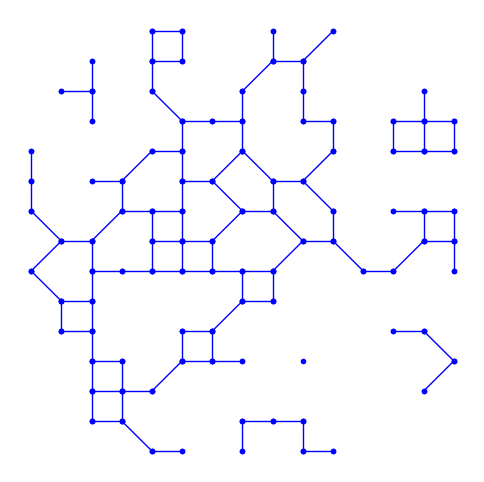

In [11]:
random.seed(our_seed)
V, E = generateRandomGraph(100, 4500)
disconnected_plot = plotGraph(V, E,location=r"C:\Users\steve_niur\Desktop\Modelling, Simulation and Optimisation\X23299525_MSO_Project\disconected_graph.png")


Since the figure above has nodes that are not connected to the rest of the nodes, these are called sub-graphs. For this project, there must be no sub-graphs. This would lead to the possibility of houses being in subgraphs with no access for the delivery driver.

In [12]:
def subgraph(P, E):
    P = P.copy()
    E = E.copy()
    PP = [ P[0] ] 
    EE = []
    P = P[1:]
    extended = True
    while extended:
        extended = False
        for (a, b) in E:
            if a in PP and b in P:
                PP.append(b)
                P.remove(b)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in P and b in PP:
                PP.append(a)
                P.remove(a)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in PP and b in PP:
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
    return PP, EE, P, E    

## Lists and Paths

In [13]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [14]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]

In [15]:
def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return None

In [16]:
def addWithoutDuplicates(L, X):
    for i in range(len(X)):
        if X[i] not in L:
            L.append(X[i])
    return L

In [17]:
def totalLength(edges):
    return sum([ dist(A, B) for A,B in edges ])

## Generate Customer Data

In [18]:
def splitEdgeRandomly(V, E, s):
    A, B = s
    p = random.uniform(0.3,0.7)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [19]:
def generateRandomTargets(M, n=5):
    V, E = M
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 200
    while len(T)<n:
        s = random.choice(E)
        A, B = s
        if dist(A,B)>mindist: # avoid targets placed narrowly
            (V, E), t = splitEdgeRandomly(V, E, s)
            T.append(t)
    return sorted(T)

In [20]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## Plot Map With Delivery Route

In [21]:
def label(i):
    return (label(i//26-1)+chr(65+i%26)) if i>25 else chr(65+i)

In [22]:
def plotMap(G, location=None,T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=3,
            styleP='b-o', lwP=2, msP=3,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False, labels=False, scale=False):


    V, E = G

    def round_down(x, level): return (x//level)*level
    def round_up(x, level): return (x//level+1)*level
    
    xmin = round_down(min([ x for (x, _) in V ]), 100)
    xmax = round_up(max([ x for (x, _) in V ]), 100)
    ymin = round_down(min([ y for (_, y) in V ]), 100)
    ymax = round_up(max([ y for (_, y) in V ]), 100)
    dx = xmax-xmin
    dy = ymax-ymin
    yoffset = (ymax-ymin)//10
    
    fig = plt.gcf()
    fig.set_size_inches(4, 4)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin-yoffset, ymax)
    
    if not grid:
        plt.axis('off')

    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    if scale:
        # plot 1000m scale
        ybar = ymin-0.9*yoffset
        D = [ (xmin, ybar+50), (xmin, ybar), (xmin+1000, ybar), (xmin+1000, ybar+50) ]
        plt.plot( [ d[0] for d in D ], [ d[1] for d in D ], 'k-', lw=0.5)
        plt.text(xmin+500, ymin-0.7*yoffset, '1000m' , horizontalalignment='center', size=8)
    
    if labels:
        for i in range(len(V)):
            x, y = V[i]
            plt.text(x+0.0150*dx, y-0.0350*dy, label(i), size=8)
        
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
        
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(xmax, ymin-0.7*yoffset, text, horizontalalignment='right', size=8)
    if grid:
        plt.grid()
    if location: 
        plt.savefig(location)
    plt.show()

In [23]:
def generateGraph(n, r):
    P, E = generateRandomGraph(n, r)
    P0, _, P1, _ = subgraph(P, E)
    while len(P1)>0:
        (p, q) = nearest(P0, P1)
        E.append((p, q))
        P0, _, P1, _ = subgraph(P, E)
    return P, E

## Generate Data

generateData is a function that takes in the seed value (student number), a number of nodes, customers, a plot value, if you would like the data plotted & a log value - if you would like to know it was successful

In [24]:
def generateData(seed=None, nodes=35, customers=100, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=35, customers=100, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations.")
        print("")
        print("  nodes the number of intersections (nodes, vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 20       # number of points in map
        customers = 5    # number of  customers
        grid = True
        scale = False
            
    else:
        grid = False
        scale = True
        
    random.seed(seed)
    
    M = generateGraph(nodes, 4500)
    
    C = generateRandomTargets(M, customers)
    
    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap(M, T=C, scale=scale, text=label, grid=grid)
    
    return M, C

Now that the data can be generated, a quick test can be done to ensure we have replicable results. 

In [25]:
D1 = generateData(our_seed)
D2 = generateData(our_seed)
D1 == D2

True

Ensure that the above is "True" before proceeding. This ensured that the code is set up correctly and the generateData function can produce replicable results

## Generate project map and customers

The next stage is to use the above functions to generate the map, M and customers, C that will be used for this project

In [26]:
M, C = generateData(9525)

In [27]:
def generateRandomGraph(n, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    r = rounding(r)
    x0 = r
    y0 = r
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = r//gridsize*gridsize
    split = 2*r//gridsize+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) <= r*1.2 ]
    P = random.sample(P, k=n)
    
    E = []
    
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
            
    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )
        
    return sorted(P), sorted(E)

## Generating Test Data

Generated map with 35 nodes and 100 customer locations


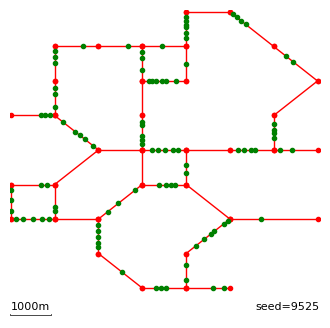

In [88]:
FullData = generateData(seed=our_seed, log=True, plot=True)

In [89]:

with open('FullData.pickled', 'wb') as f:
    pickle.dump(FullData, f)
    

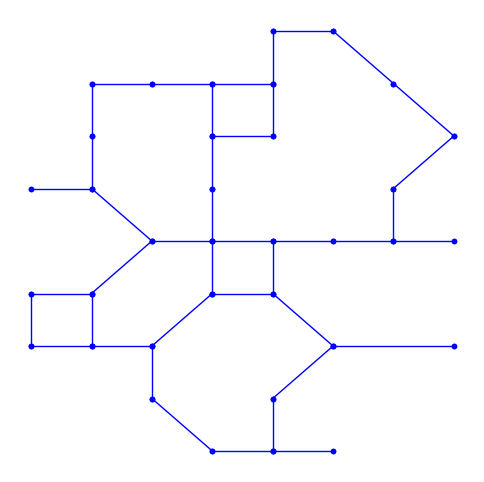

In [90]:
M, C = FullData
V,E = M

plotGraph(V, E,location=r"C:\Users\steve_niur\Desktop\Modelling, Simulation and Optimisation\X23299525_MSO_Project\testData.png")

## Generate Warehouse Location

The Next step in the project is to generate the first warehouse location, the code is set up so this is somewhere in the center of the map. 

In [31]:

def generateWarehouseLocation(M):
    V, _ = M
    xc = median([ x for (x, y) in V ])
    yc = median([ y for (x, y) in V ])
    cloc = (xc, yc)
    minloc = V[0]
    mindist = dist(minloc, cloc)
    for i in range(1, len(V)):
        d = dist(V[i], cloc)
        if d<mindist:
            minloc = V[i]
            mindist = dist(V[i], cloc)
    return minloc

In [32]:
def generateMultipleWarehouseLocations(M, N=5):
    C = generateWarehouseLocation(M)
    V, _ = M
    distances = [ (i, pathLength(shortestPath(M, V[i], C))) for i in range(len(V)) ]
    faraway = sorted(distances, key=lambda x: x[1], reverse=True)
    index = [ i*(len(faraway)-1)//(N-1) for i in range(N)]
    locations = [ V[faraway[i][0]] for i in index ]
    return locations

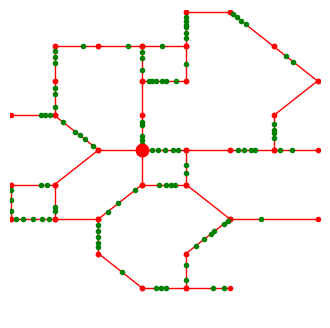

In [33]:
W = generateWarehouseLocation(M)
plotMap((V, E),location=r"C:\Users\steve_niur\Desktop\Modelling, Simulation and Optimisation\X23299525_MSO_Project\warehouselocation1.png", T=C, w=W)

# Generating the Delivery Data

In [34]:
def generateDeliveries(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    random.seed(seed)
    deliveries = [ [ ] for _ in range(days) ]
    for c in range(C):
        arr = 0
        while True:
            arr += random.expovariate(p)
            day = int(arr)
            if day>=days:
                break
            deliveries[day].append(c)
    return deliveries 

# Finding the shortest path

The A* Algorithm

In [57]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [58]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

Update to our seed?

In [35]:
D = generateDeliveries(0.2, 10, 5, seed=42)
D

[[1, 4, 5, 8], [1, 5], [1], [4, 4, 6], [4, 7]]

In [36]:
def simulateDeliveriesPerDay(p, C=100, days=100, n=1000):
    deliveries = []
    for seed in range(n):
        D = generateDeliveries(p, C, 50, seed=seed)
        deliveries += [len(d) for d in D]
    
    mind = min(deliveries)
    maxd = max(deliveries)
    
    plt.hist(deliveries, bins=maxd-mind+1, density=True)
    plt.title(f"Total Parcels per Day p={p:4.2f}, C={C:d} (days={days:d}, n={n:d})")
    poisson=stats.poisson(p*C)
    X = range(mind, maxd+1)
    plt.plot( X, [ poisson.pmf(x) for x in X ], color='red', marker='o')
    plt.show()

In [37]:
def simulateDeliveriesPerCustomer(p, days=100, C=100, n=1000, log=False):
    total = [ 0 for c in range(C) ]
    mind = maxd = int(p*days)
    counts = [0]
    assert(len(counts) == maxd-mind+1)
    for seed in range(n):
        deliveries = [ 0 for c in range(C) ]
        D = generateDeliveries(p, C, days, seed=seed)
        for d in D:
            for c in d:
                deliveries[c] += 1
                
        # extend count to the left if required
        for i in range(mind-min(deliveries)):
            counts = [0] + counts
        # extend count to the right if required
        for i in range(max(deliveries)-maxd):
            counts = counts + [0]
        mind = min(mind, int(min(deliveries)))
        maxd = max(maxd, int(max(deliveries)))
        assert(len(counts) == maxd-mind+1)
        
        for c in range(C):
            counts[deliveries[c]-mind] += 1

    if not log:
        for i in range(len(counts)):
            counts[i] = counts[i]/(n*C)
            
    plt.bar(x=[str(i) for i in range(mind, maxd+1)], height=counts, log=log)
    plt.title(f"Parcels per Customer p={p:4.2f}, days={days:d} (C={C:d}, n={n:d})")

    poisson=stats.poisson(p*days)
    X = range(mind, maxd+1)
    Y = [ poisson.pmf(x) for x in X ]
    
    if log:
        Y = [ n*C*y for y in Y ]
    
    plt.plot( X, Y, color='red', marker='o')
    plt.show()

## Statistical Analysis

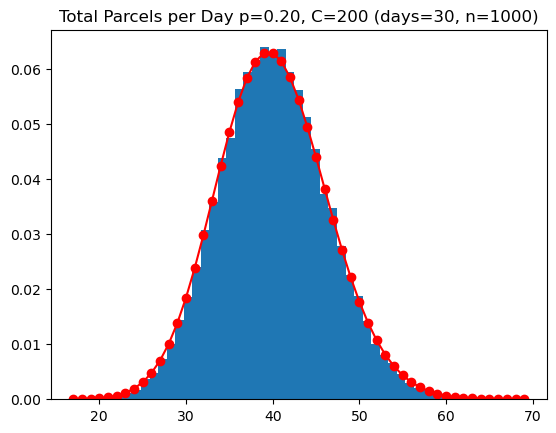

In [38]:
simulateDeliveriesPerDay(0.2, C=200, days=30)

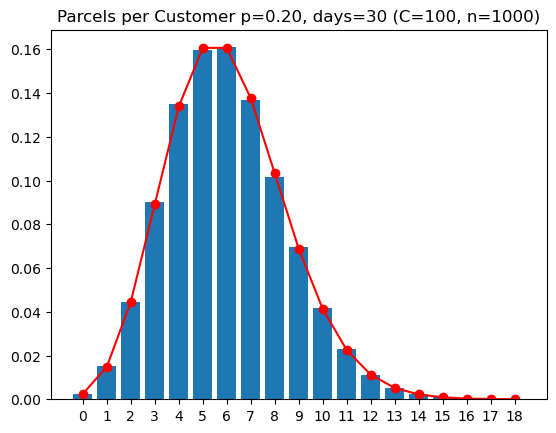

In [39]:
simulateDeliveriesPerCustomer(0.2, days=30)

# Delivery Route Algorithms

## Greedy Algorithm

Space for info on the greedy algorithm

In [40]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

In [41]:
def createLoopG(M, T, plot=False, timing=False):

    def makeLoop(V, P, L):
        loop = []
        for i in range(len(L)-1):
            sub = P[V.index(L[i])][V.index(L[i+1])]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
        
    if timing:
        start_time = time.time()

    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    # D, P = createTables(M, T)   # note these are the distances between all vertices in M (and T)
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:2]+[T[0]]
        T = T[2:]
        while len(T)>0:
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):  
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            if plot:
                print('-'.join([ label(V.index(l)) for l in L ]))
                loop = makeLoop(V, P, L)
                plotMap(M, T=L, P=loop, w=W, labels=True, 
                        text=f"{len(L):d} steps {pathLength(loop):,d}m")
                
    if timing:
        print(f"createLoopG:    {time.time()-start_time:6.2f}s")
        
    return makeLoop(V, P, L)

In [70]:
import pickle
with open('testData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [71]:
W = generateWarehouseLocation(M)

In [72]:
random.seed(0)
T = random.sample(C, k=len(C)//2)

In [73]:
MC = addTargets(M, T)

In [75]:
PG = createLoopG(MC, [W]+T, plot=False)

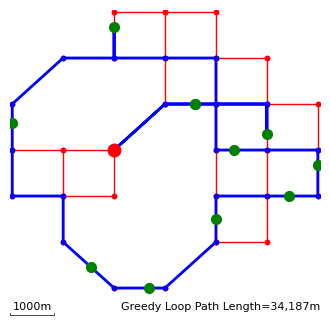

In [76]:
plotMap(MC, T=T, w=W, P=PG, scale=True, text=f"Greedy Loop Path Length={pathLength(PG):3,d}m")

## Statistics of Greedy Delivery Path Length

In [48]:
def simulateGreedyPathLength(p, M, C, days=10, seed=0, log=False):
    D = generateDeliveries(p, len(C), days=days, seed=seed)
    L = []
    for d in range(len(D)):
        T = [ C[c] for c in set(D[d]) ]
        MT = addTargets(M, T)
        P = createLoopG(MT, [W]+T)
        PL = pathLength(P)
        L.append(PL)

    fig = plt.figure()
    fig.set_figwidth(4)
    fig.set_figheight(4)
    ax = fig.gca()
    delta = 1000
    def roundDown(x): return x//delta*delta
    def roundUp(x): return (x//delta+1)*delta
    mind = roundDown(min(L))
    maxd = roundUp(max(L))
    bins = [ l for l in range(mind, maxd+delta, delta) ]
    res = plt.hist(L, bins=bins, log=log)
    mean = statistics.mean(L)
    ax.axvline(x=mean, color='red')
    yt = 0.95*max(res[0])
    xt = 0.02*(max(res[1])-min(res[1]))
    ax.text(mean+xt, yt, f'μ={mean:2.2f}', color='red', fontsize=10)
    plt.title(f"Greedy Delivery Path Length p={p:4.2f}, C={len(C):d} (days={days:d})")
    plt.show()

Test (delete)

In [78]:
import pickle
with open('testData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [79]:
W = generateWarehouseLocation(M)

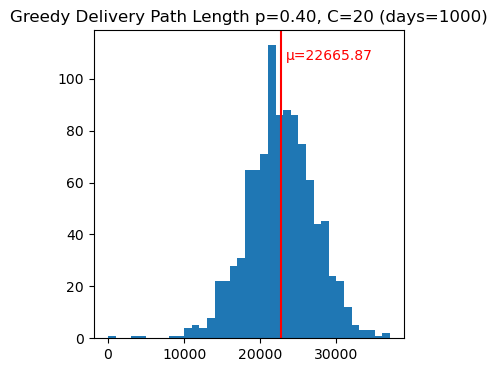

In [80]:
simulateGreedyPathLength(0.4, M, C, days=1000)

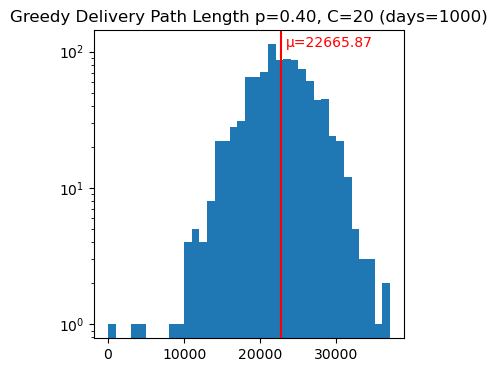

In [81]:
simulateGreedyPathLength(0.4, M, C, days=1000,log=True)

## Finding Optimal Delivery Path

In [50]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p       

In [51]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [52]:
def createLoop(M, T, timing=False):
    
    if timing:
        start_time = last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
                
    def cycles(k, n):
        if k==1:
            return [ [i] for i in range(0,n) ]
        else:
            sc=cycles(k-1, n)
            all=[]
            for c in sc:
                for i in range(0,n):
                    if c.count(i)==0:
                        all.append(c+[i])
            return all

    for k in range(3, 4):   
        cycs=cycles(k,n)
        for c in cycs:
            c.append(c[0])
            prob+=pulp.lpSum([ x[c[i]][c[i+1]] for i in range(0,k)]) <= k-1
            constraints += 1    
            
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0, timeLimit=2)
    res = prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()
        
    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
                
        res = prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

## Testing (delete?)

In [64]:
import pickle
with open('testData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [65]:
print(M)
print(C)

([(1050, 3350), (1050, 4500), (1050, 5650), (2200, 2200), (2200, 3350), (2200, 4500), (2200, 6800), (3350, 1050), (3350, 3350), (3350, 4500), (3350, 6800), (3350, 7950), (4500, 1050), (4500, 5650), (4500, 6800), (4500, 7950), (5650, 2200), (5650, 3350), (5650, 4500), (5650, 5650), (5650, 6800), (5650, 7950), (6800, 2200), (6800, 3350), (6800, 4500), (6800, 5650), (6800, 6800), (7950, 3350), (7950, 4500), (7950, 5650)], [((1050, 3350), (1050, 4500)), ((1050, 3350), (2200, 3350)), ((1050, 5650), (1050, 4500)), ((2200, 2200), (2200, 3350)), ((2200, 2200), (3350, 1050)), ((2200, 3350), (3350, 3350)), ((2200, 4500), (1050, 4500)), ((2200, 4500), (2200, 3350)), ((2200, 4500), (3350, 4500)), ((2200, 6800), (1050, 5650)), ((2200, 6800), (3350, 6800)), ((3350, 4500), (3350, 3350)), ((3350, 4500), (4500, 5650)), ((3350, 7950), (3350, 6800)), ((4500, 1050), (3350, 1050)), ((4500, 1050), (5650, 2200)), ((4500, 6800), (3350, 6800)), ((4500, 6800), (4500, 5650)), ((4500, 6800), (4500, 7950)), ((4500

In [66]:
W = generateWarehouseLocation(M)
random.seed(0)


In [67]:
T = random.sample(C, k=len(C)//2)
MC = addTargets(M, T)


In [68]:
P = createLoop(MC, [W]+T)


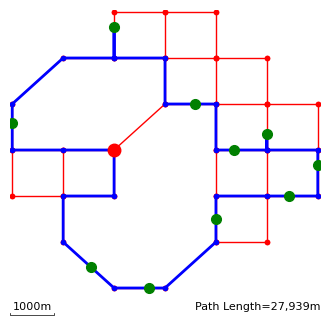

In [69]:
plotMap(MC, T=T, w=W, P=P, scale=True, text=f"Path Length={pathLength(P):3,d}m")

Comparing with the optimal delivery route with the result of the greedy algorithm:

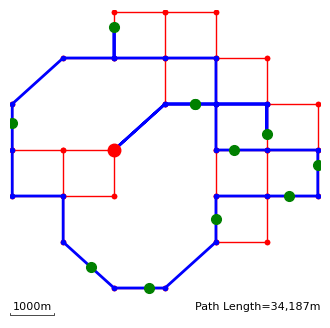

In [82]:
plotMap(MC, T=T, w=W, P=PG, scale=True, text=f"Path Length={pathLength(PG):3,d}m")

In [83]:
def simulateOptimalPathLength(p, M, C, days=10, seed=0, log=False):
    D = generateDeliveries(p, len(C), days=days, seed=seed)
    L = []
    for d in range(len(D)):
        T = [ C[c] for c in set(D[d]) ]
        MT = addTargets(M, T)
        P = createLoop(MT, [W]+T)
        PL = pathLength(P)
        L.append(PL)

    fig = plt.figure()
    fig.set_figwidth(4)
    fig.set_figheight(4)
    ax = fig.gca()
    delta = 1000
    def roundDown(x): return x//delta*delta
    def roundUp(x): return (x//delta+1)*delta
    mind = roundDown(min(L))
    maxd = roundUp(max(L))
    bins = [ l for l in range(mind, maxd+delta, delta) ]
    res = plt.hist(L, bins=bins, log=log)
    mean = statistics.mean(L)
    ax.axvline(x=mean, color='red')
    yt = 0.95*max(res[0])
    xt = 0.02*(max(res[1])-min(res[1]))
    ax.text(mean+xt, yt, f'μ={mean:2.2f}', color='red', fontsize=10)
    plt.title(f"Optimal Delivery Path Length p={p:4.2f}, C={len(C):d} (days={days:d})")
    plt.show()

In [84]:
D = generateDeliveries(0.4, len(C), days=10)
for d in D:
    print(d)

[9, 10, 11, 13, 16]
[1, 6, 6, 10, 14, 16, 16]
[3, 11, 13, 15]
[1, 3, 5, 6, 9, 11]
[0, 4, 9, 12, 15, 16, 18]
[2, 6, 8, 8, 12, 12, 13, 15, 17]
[1, 10, 12, 16, 19]
[1, 2, 10, 13]
[0, 2, 5, 7, 9, 10, 12, 15, 16, 16, 19]
[0, 1, 3, 4, 8, 15, 19]


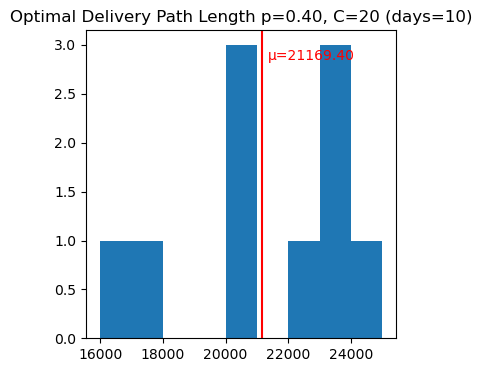

In [85]:
simulateOptimalPathLength(0.4, M, C, days=10)

## Path Planning for full data - Delete?

In [91]:
import pickle
with open('FullData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [92]:
W = generateWarehouseLocation(M)

In [93]:
len(C)

100

In [94]:
D = generateDeliveries(0.2, len(C), days=10)
for d in D:
    print(d)

[14, 19, 20, 42, 47, 47, 50, 54, 55, 57, 64, 80, 89, 95]
[8, 13, 16, 17, 25, 32, 40, 42, 48, 48, 52, 59, 64, 68, 76, 79, 85, 85, 85, 93, 95, 96, 97, 97]
[1, 19, 25, 41, 46, 48, 50, 51, 56, 60, 60, 61, 63, 67, 68, 75, 81, 81, 97, 98]
[4, 12, 16, 21, 22, 25, 26, 26, 31, 39, 44, 50, 51, 52, 56, 58, 60, 61, 64, 70, 77, 83, 98, 99]
[1, 3, 5, 10, 20, 23, 24, 34, 35, 45, 50, 57, 64, 66, 77, 77, 81, 96]
[4, 9, 15, 15, 17, 19, 55, 58, 59, 59, 60, 62, 63, 70, 73, 73, 90, 92, 93, 93]
[5, 14, 17, 24, 31, 50, 51, 51, 54, 57, 61, 66, 68, 93, 94, 97, 97]
[1, 2, 35, 38, 40, 42, 42, 51, 58, 69, 76, 76, 81, 85, 89, 92]
[7, 8, 9, 14, 15, 18, 25, 38, 39, 40, 45, 56, 67, 67, 70, 72, 75, 83, 93, 94, 96]
[0, 2, 9, 13, 23, 29, 32, 40, 44, 44, 52, 62, 64, 66, 68, 72, 82, 96, 97]


Day 0:


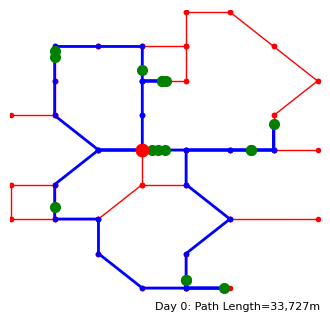

Day 1:


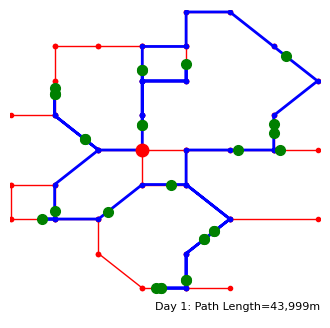

Day 2:


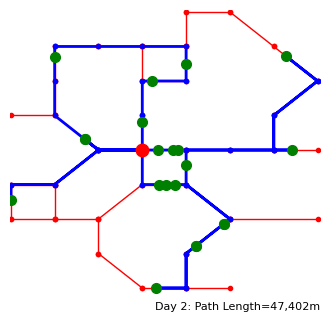

Day 3:


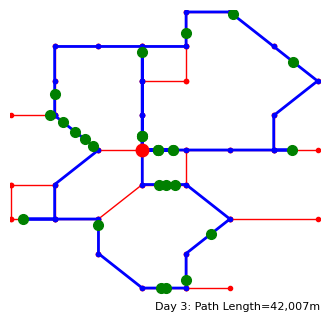

Day 4:


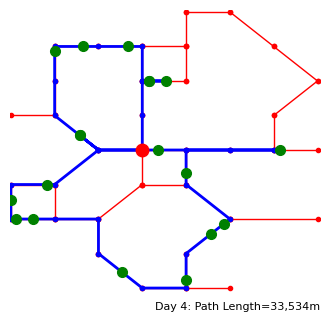

Day 5:


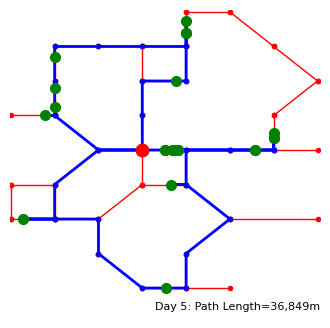

Day 6:


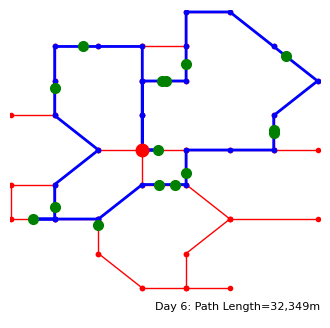

Day 7:


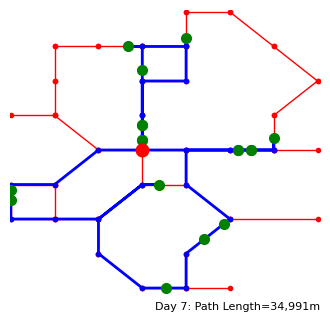

Day 8:


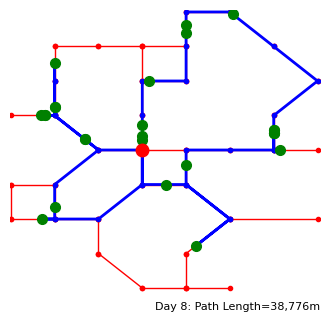

Day 9:


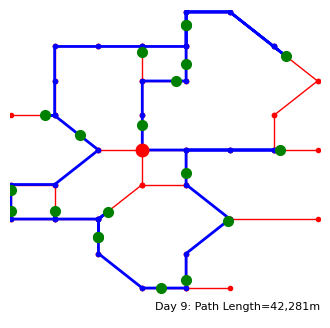

In [95]:
length = []
for d in range(len(D)):
    print(f"Day {d}:")
    T = [ C[c] for c in set(D[d]) ]
    MT = addTargets(M, T)
    P = createLoopG(MT, [W]+T)
    length.append(pathLength(P))
    plotMap(MT, T=T, w=W, P=P, text=f"Day {d}: Path Length={pathLength(P):3,d}m")

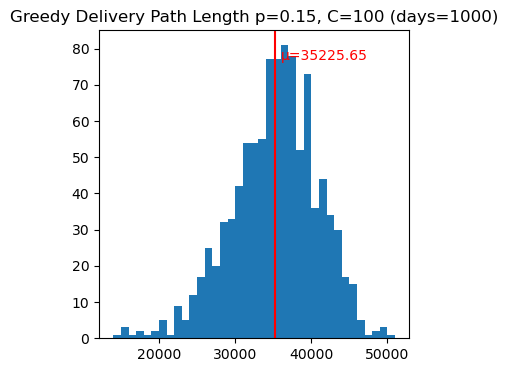

In [96]:
simulateGreedyPathLength(0.15, M, C, days=1000)

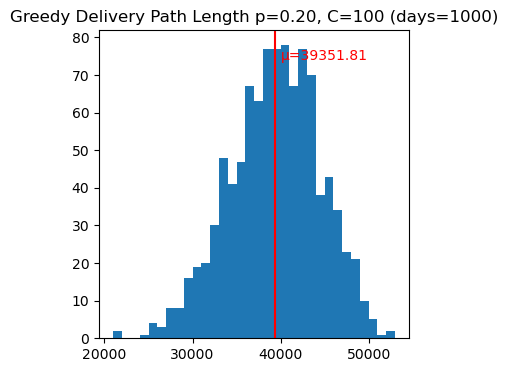

In [97]:
simulateGreedyPathLength(0.2, M, C, days=1000)

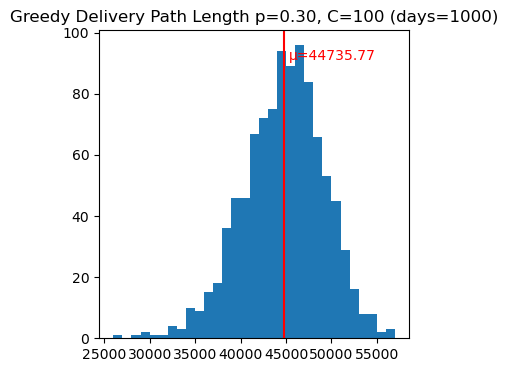

In [98]:
simulateGreedyPathLength(0.3, M, C, days=1000)

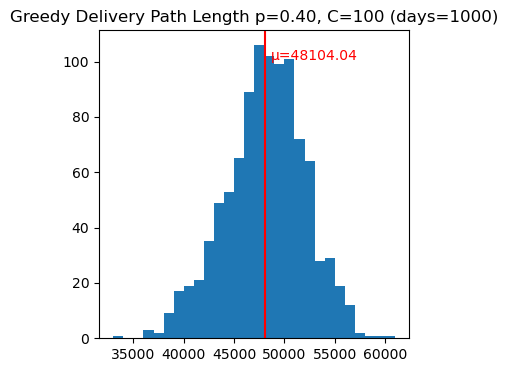

In [99]:
simulateGreedyPathLength(0.4, M, C, days=1000)

# STEP 4